In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math 
import fiona
import shapely
import shapefile
import rasterio
from shapely.geometry import shape, Point
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.plot import show

<AxesSubplot:>

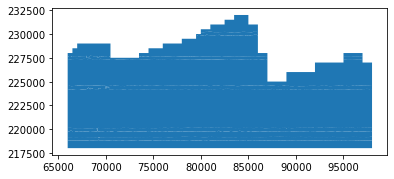

In [2]:
dsm_shp = gpd.read_file('data/dsm/DHMVII_vdc_k5.shp')
dsm_shp = dsm_shp.set_crs('epsg:31370')
dsm_shp.plot()

In [3]:
img = rasterio.open('data/geotif/dsm/DHMVIIDSMRAS1m_k05.tif')

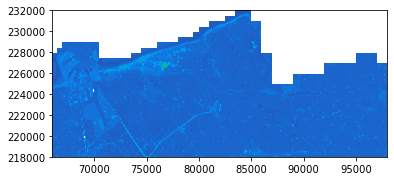

<AxesSubplot:>

In [4]:
rasterio.plot.show(img, cmap='terrain')

In [13]:
left = 66000
bottom = 222000
right = 75000
top = 226500

rst = img.read(1, window=from_bounds(left, bottom, right, top, img.transform))

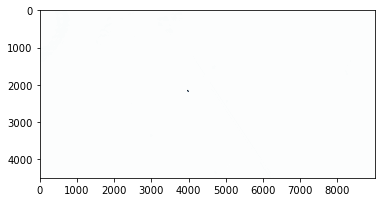

In [15]:
rasterio.plot.show(rst, cmap = 'bone')
plt.show()

#### transform long and lat degrees to x and y coordinates

In [7]:
# bruge coordinates decimal
lat_bruge = 51.20892
long_bruge = 3.22424

In [8]:
# SOURCE: https://stackoverflow.com/questions/58623254/find-pixel-coordinates-from-lat-long-point-in-geotiff-using-python-and-gdal


from osgeo import osr, ogr, gdal

def world_to_pixel(geo_matrix, x, y):
    """
    User a gdal geomatrix (gdal.GetGeoTransform()) to calculate the pixel location of a geospatial coordinate
    """
    ul_x = geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = -((x - ul_x) / x_dist)
    line = -((ul_y - y) / y_dist)
    return pixel, line

# Extract target reference from the tiff file
ds = gdal.Open('data/geotif/dsm/DHMVIIDSMRAS1m_k05.tif')
target = osr.SpatialReference(wkt=ds.GetProjection())

source = osr.SpatialReference()
source.ImportFromEPSG(31370)

transform = osr.CoordinateTransformation(source, target)

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long_bruge, lat_bruge)
point.Transform(transform)

x, y = world_to_pixel(ds.GetGeoTransform(), point.GetX(), point.GetY())
print(x,y)


65996.77576 231948.79108


#### get long and lat from x and y

#### Convert xy raster coordinates to spatial coordinates

In [9]:
def raster_to_spatial(self, xy):
    # Check xy parameter
    xy = np.asarray(xy)
    if xy.shape[-1] != 2:
        raise ValueError('An array of shape (..., 2) was expected') # pragma: no cover
    
    workshape = int(xy.size / 2), 2
    xy2 = np.empty(workshape, 'float64')
    xy2[:, :] = xy.reshape(workshape)
    aff = self._aff
    xy2[:, 0], xy2[:, 1] = (
        xy2[:, 0] * aff.a + xy2[:, 1] * aff.b + aff.c,
        xy2[:, 0] * aff.d + xy2[:, 1] * aff.e + aff.f,
    )
    return xy2.reshape(xy.shape)    
    

In [10]:
import shapefile
from shapely.geometry import shape, Point

r = shapefile.Reader('data/dsm/DHMVII_vdc_k5.shp')
shapes = r.shapes()
polygon = shape(shapes[0])

def check(lon, lat):
    point = Point(lon,lat)
    return polygon.contains(point)

check(long_bruge, lat_bruge)

False

In [11]:
# Ellipsoid parameters: semi major axis in metres, reciprocal flattening.
GRS80 = 6378137, 298.257222100882711
WGS84 = 6378137, 298.257223563

def geodetic_to_geocentric(ellipsoid, latitude, longitude, height):
    """Return geocentric (Cartesian) Coordinates x, y, z corresponding to
    the geodetic coordinates given by latitude and longitude (in
    degrees) and height above ellipsoid. The ellipsoid must be
    specified by a pair (semi-major axis, reciprocal flattening).

    """
    φ = radians(latitude)
    λ = radians(longitude)
    sin_φ = sin(φ)
    a, rf = ellipsoid           # semi-major axis, reciprocal flattening
    e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
    n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
    r = (n + height) * cos(φ)   # perpendicular distance from z axis
    x = r * cos(λ)
    y = r * sin(λ)
    z = (n * (1 - e2) + height) * sin_φ
    return x, y, z

In [12]:
width = 800
height = 600

with rasterio.open('data/geotif/dsm/DHMVIIDSMRAS1m_k05.tif') as src:
    w = src.read(1, window=Window(0, 0, width, height))
    profile = src.profile
    profile['width'] = width
    profile['height'] = height
    # Create output
    result = np.full((width, height), dtype=profile['dtype'], fill_value=profile['nodata'])

#writting
with rasterio.open('/tmp/sampled_image.tif', 'w', **profile) as dataset:
    dataset.write_band(1, result)

#plotting
with rasterio.open('/tmp/sampled_image.tif') as src:
    pyplot.imshow(src.read(1), cmap='pink')
    pyplot.show()

NameError: name 'Window' is not defined